In [250]:
from __future__ import division

In [321]:
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt

In [110]:
pi = np.pi
twopi = 2*pi

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

In [40]:
import helpy

In [38]:
import tracks, otracks
import orientation as orient
import correlation as corr

In [620]:
S = 17.5
fps = 120
freq = 50

In [8]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
smallfig = (5,4)
largefig = (8,6)

In [9]:
locdir = '/Users/leewalsh/Physics/Squares/Noise/Walker/'

In [21]:
dataset_names = ['n8_100mv_50hz_{}'.format(i) for i in range(1,5)] + ['n2_pAB_1', 'n2_pAB_2', 'n2_pBC']

In [91]:
odata.dtype.names

('corner', 'orient', 'cdisp')

In [627]:
prefix = dataset_names[0]
def loadall(prefix):
    data, trackids, odata, omask = helpy.load_data(locdir+prefix, ret_odata=True, ret_cdata=False)
    fsets = helpy.splitter(data, ret_dict=True)
    fosets = helpy.splitter(odata[omask], data['f'], ret_dict=True)
    longtracks = np.argwhere(np.bincount(trackids) > 1000).flatten()
    tracksets  = { track:  data[(data['lab']==track)&omask]
                   for track in longtracks}
    otracksets = { track: orient.track_orient(odata[(data['lab']==track)&omask]['orient'], onetrack=True)
                   for track in longtracks}
    msds, msdids, msads, msadids, dtau, dt0 = helpy.load_MSD(locdir+prefix, True, True)
    return data, tracksets, odata, otracksets, msds, msdids, msads, msadids, dtau, dt0

In [251]:
[len(tracksets[track]) for track in longtracks]

[7535, 7710, 7722, 7709, 7708, 7676, 7692, 7660]

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 400 px^2


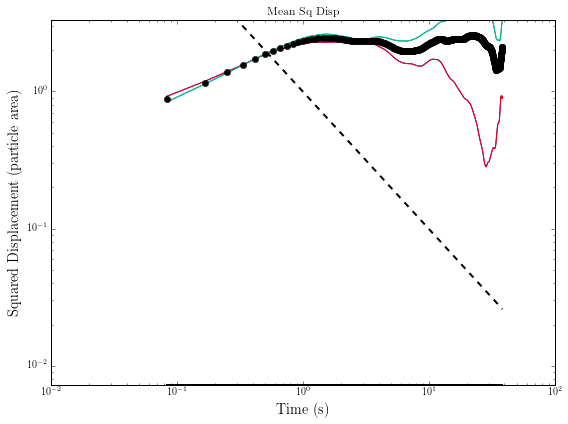

In [241]:
tracks.plot_msd(msds, msdids, dtau, dt0, nframes=len(fsets), tnormalize=1,
                fps=fps, S=S, #approx...
                figsize=largefig,
                #ylim=((msds[...,1]/msds[...,0]).min(),(msds[...,1]/msds[...,0]).max())
               )

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 1 px^2


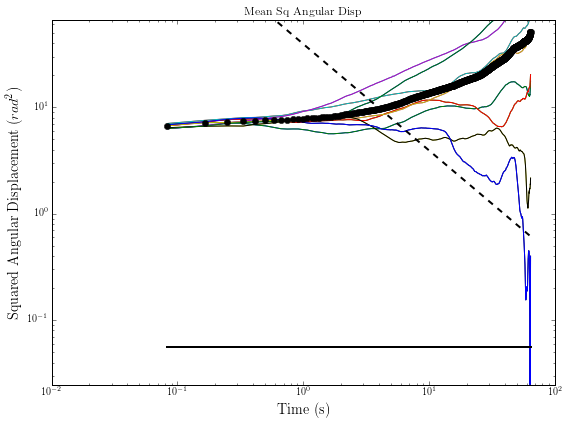

In [182]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframes=len(fsets), ang=True, tnormalize=1,
                fps=fps, S=S, figsize=largefig)

In [186]:
rot_step = np.mean([np.abs(np.diff(odata[(data['lab']==track)&omask]['orient'])).mean()
                                          for track in longtracks])
print rot_step/pi, "* pi"

0.0729709440103 * pi


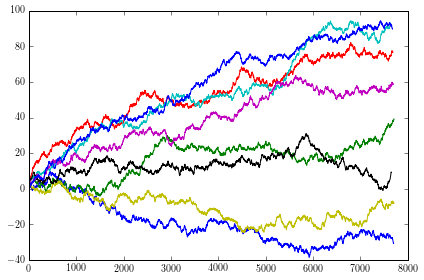

In [187]:
for track in longtracks:
    plt.plot(otracksets[track])

In [628]:
# Build up data dicts by track for all datasets
alltracksets = {}
allotracksets = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    data, tracksets, odata, otracksets, msds, msdids, msads, msadids, dtau, dt0 = loadall(prefix)
    alltracksets[prefix] = tracksets
    allotracksets[prefix] = otracksets

n8_100mv_50hz_1
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
n8_100mv_50hz_2
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
n8_100mv_50hz_3
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
n8_100mv_50hz_4
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4


In [598]:
# Calculate all <nn> correlations
# That is, <cos(phi) cos(phi)> and <sin(phi) sin(phi)>
allocoscorr = {} # this is <n_i n_i>, the ii component of <nn>
allosincorr = {} # and <n_j n_j>, the jj component of <nn>
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    otracksets = allotracksets[prefix]
    allocoscorr[prefix] = {track: corr.autocorr(np.cos(otrackset)) for track, otrackset in otracksets.items()}
    allosincorr[prefix] = {track: corr.autocorr(np.sin(otrackset)) for track, otrackset in otracksets.items()}

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4


[ 12.46272235   1.02961404]


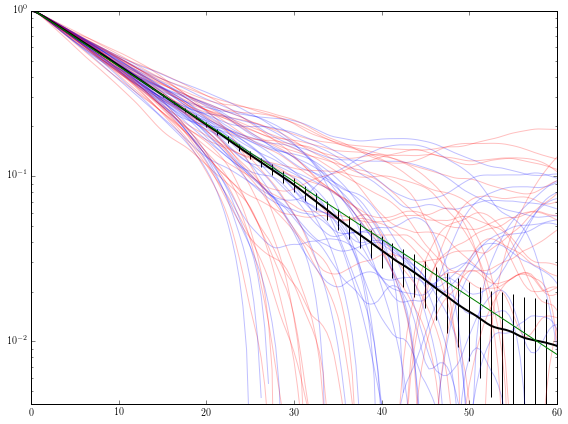

In [793]:
# Average, Fit and plot <nn> correlation
plt.figure(figsize=largefig)

allcorr = []
nframes = 2000
tcorr = np.arange(nframes)*freq/fps
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    normed = prefix.endswith('1') or prefix.endswith('2')
    color = 'b' if normed else 'r'
    for track in allotracksets[prefix]:
        coscorr = allocoscorr[prefix][track][:nframes]
        sincorr = allosincorr[prefix][track][:nframes]
        allcorr.append(coscorr)
        allcorr.append(sincorr)
        plt.semilogy(tcorr, coscorr, 'b', alpha=.25)
        plt.semilogy(tcorr, sincorr, 'r', alpha=.25)
allcorr = np.asarray(allcorr)
meancorr = np.mean(allcorr, 0)
errcorr = np.std(allcorr, 0)/sqrt(len(allcorr))
err_offset = errcorr.mean()
tmax = 60

plt.errorbar(tcorr, meancorr, errcorr, None, 'k',capthick=0, lw=2, elinewidth=1, errorevery=3)
plt.xlim(0, tmax)
fmax = np.searchsorted(tcorr, tmax)
popt, pcov = curve_fit(corr.exp_decay, tcorr[:fmax], meancorr[:fmax],
                       p0=[10,1], sigma=err_offset + errcorr[:fmax])
print popt
D_R = 1/popt[0]
plt.semilogy(tcorr, corr.exp_decay(tcorr, *popt), 'g')
#plt.yscale('linear')
plt.ylim(corr.exp_decay(tmax, *popt)/2, 1)
plt.legend()

In [802]:
reload(corr)

<module 'correlation' from 'correlation.py'>

In [803]:
# Calculate all <rn> correlations
# That is, <x cos(phi)> and <y sin(phi)>
#alloxcorr = {}
#alloycorr = {}
corr_args = {'side': 'left', 'cumulant': False, 'normalize': False, 'verbose': False, 'shift': True}
zero_by = '0' #r0 #mean

zeros = {'0': lambda arr: 0, 'mean': lambda arr: arr.mean(),'r0': lambda arr: arr[0]}
zero =  zeros[zero_by]
setup = ('normed,' if corr_args['normalize'] else 'unnormed') + '-' + zero_by +',shift'*corr_args['shift']
alloxcorr[setup] = {}
alloycorr[setup] = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    tracksets = alltracksets[prefix]
    otracksets = allotracksets[prefix]
    alloxcorr[setup][prefix] = {track: corr.crosscorr(tracksets[track]['x']/S - zero(tracksets[track]['x'])/S,
                                               np.cos(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}
    alloycorr[setup][prefix] = {track: corr.crosscorr(tracksets[track]['y']/S - zero(tracksets[track]['y'])/S,
                                               np.sin(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}
print alloxcorr.keys()

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4
['normed,-r0', 'unnormed-0,shift', 'unnormed,-r0', 'normed,-mean', 'unnormed,-mean', 'unnormed-0']


normed,-r0
[-1.26809581]
-1.26809581177 0.0 (2000,)
0.0 832.916666667 (2000,)
unnormed-0,shift
[-0.03345586]
-0.0334558610491 0.0 (2000,)
0.0 832.916666667 (2000,)
unnormed,-r0
[ 0.11308501]
0.0 0.113085013854 (2000,)
0.0 832.916666667 (2000,)
normed,-mean
[ 24.73869985]
0.0 24.7386998538 (2000,)
0.0 832.916666667 (2000,)
unnormed,-mean
[-0.1334144]
-0.133414402213 0.0 (2000,)
0.0 832.916666667 (2000,)
unnormed-0
[-0.03342527]
-0.0334252691546 0.0 (2000,)
0.0 832.916666667 (2000,)


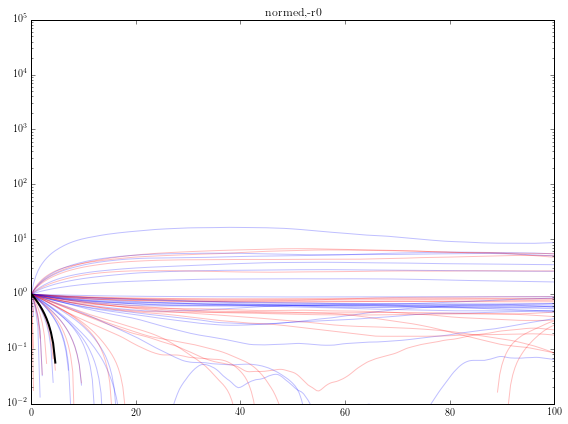

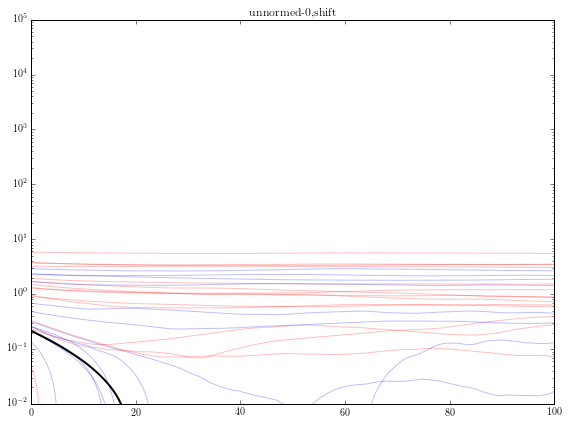

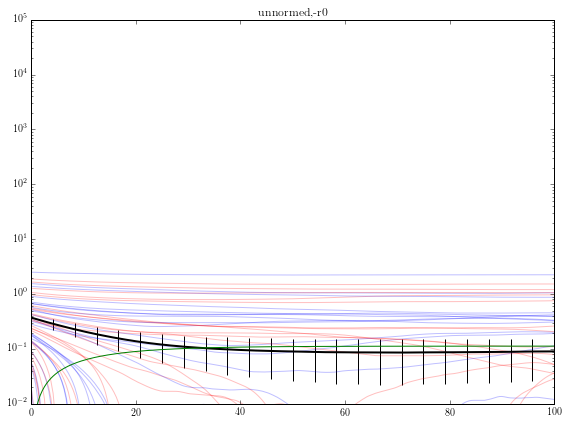

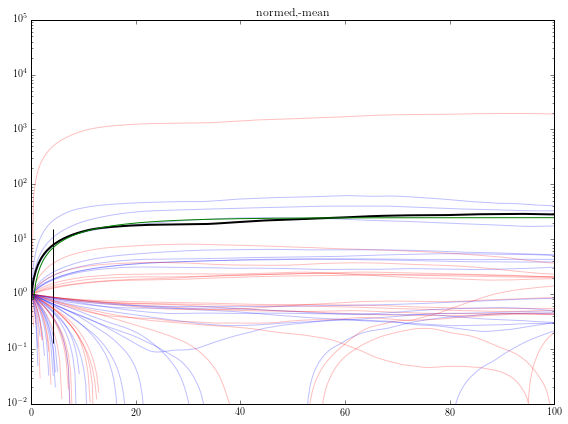

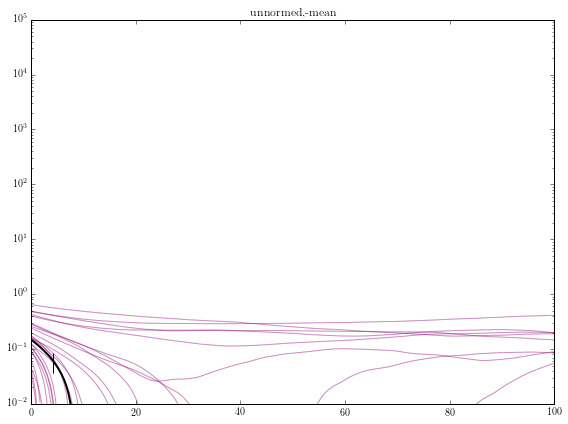

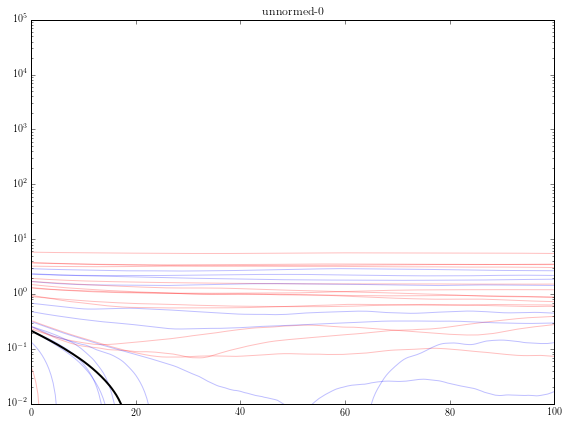

In [804]:
# Average, Fit and plot <rn> correlation
for setup in alloxcorr.keys():
    print setup
    plt.figure(figsize=largefig)
    plt.title(setup)
    allcorr = []
    nframes = 2000
    tcorr = np.arange(nframes)*freq/fps
    for prefix in dataset_names:
        if 'n8' not in prefix: continue
        for track in allotracksets[prefix]:
            oxcorr = alloxcorr[setup][prefix][track][:nframes]
            oycorr = alloycorr[setup][prefix][track][:nframes]
            allcorr.append(oxcorr)
            allcorr.append(oycorr)
            plt.semilogy(tcorr, oxcorr, 'b', alpha=.25)
            plt.semilogy(tcorr, oycorr, 'r', alpha=.25)
    allcorr = np.asarray(allcorr)
    meancorr = np.nanmean(allcorr, 0)
    errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
    err_offset = errcorr.mean()
    tmax = 100
    plt.errorbar(tcorr, meancorr, errcorr, None, 'k',capthick=0, lw=2, elinewidth=1, errorevery=10)
    plt.xlim(0, tmax)
    fmax = np.searchsorted(tcorr, tmax)
    fitform = lambda s, a: a - corr.exp_decay(s, 1/D_R, a)
    popt, pcov = curve_fit(fitform, tcorr[:fmax], meancorr[:fmax],
                           p0=[1], sigma=err_offset + errcorr[:fmax]
                           )
    print popt
    fit = fitform(tcorr, *popt)
    print fit.min(), fit.max(), fit.shape
    print tcorr.min(), tcorr.max(), tcorr.shape
    plt.semilogy(tcorr, fit, 'g')
    plt.ylim(1e-2, 1e5)
    #plt.yscale('linear')
    #plt.ylim(corr.exp_decay(tmax, *popt)/2, 1)
    #plt.legend()

    if False:
        plt.figure(figsize=largefig)
        for icorr in allcorr:
            plt.semilogy(tcorr, popt[1] - icorr, 'r', alpha=.25)
            plt.semilogy(tcorr, fit[fmax] - fit, 'k', lw=1)
        plt.xlim(0, tmax)
        plt.ylim(1e-2, 1e2)